# Single-Stage Global Fit

Overview:

We feed original dataset (or perhaps just the data for a specific phi) into ANN, with an architecture very similar to method 2.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

import utilities as uts

In [3]:
from BHDVCStf import BHDVCS #modified bhdvcs file

## Setup

In [56]:
numSets = 15
numReplicas = 100

df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = uts.DvcsData(df)

## Define model

In [124]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="elu")(kinematics)
outputs = tf.keras.layers.Dense(3)(x) #three output nodes for ReH, ReE, ReHtilde
noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
F = uts.TotalUUXSlayer()(totalUUXSInputs) # incorporate cross-sectional function

globalModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs=F, name="GlobalModel")

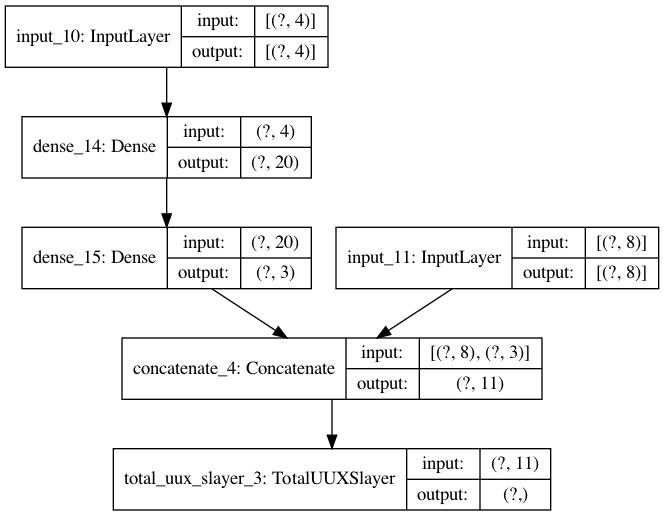

In [125]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

In [126]:
globalModel.compile(
    optimizer = tf.keras.optimizers.Adam(.01),
    loss = tf.keras.losses.MeanSquaredError(),
)

In [127]:
orig_weights = globalModel.get_weights()

## Data

In [128]:
rescaler = MinMaxScaler() # need to scale data for neural network

X = data.Kinematics.loc[np.array(range(numSets))*36, :]
rescaler = rescaler.fit(data.Kinematics)
X_rescaled = rescaler.transform(X)

xnocff = np.array(data.XnoCFF.loc[np.array(range(numSets))*36, :])

## Fit

In [164]:
def produceResults(model, X, xnocff, data, orig_weights, numSets, numReplicas, epochs=100, whichPhi=18):
    '''
    Essentially LOO cross-val with y-values being generated from seperate local fit
    
    globalModel: a tensorflow neural network model
    X: [standardized kins, xnocff]
    orig_weights: the original weights from when the model was created (used to reset model after it has been trained)
    numSets: the number of kinematic sets
    numReplicas: the number of replicas
    
    returns: np array of cff predictions of shape (numSets, numReplicas, numCFFs)
    '''
    by_set = []
    for i in tqdm(range(numSets)):
        valid_x = X[[i], :] # specific row of standardized kins
        
        train_x = np.delete(X, i, axis=0)
        train_xnocff = np.delete(xnocff, i, axis=0)
        
        msk = np.delete(np.array(range(numSets))*36 + whichPhi, i) # grab only Fs for phi=whichPhi
        
        by_rep = []
        for rep in range(numReplicas):
            train_y = np.array(data.sampleY()[msk])
            
            model.set_weights(orig_weights)
            
            #return model, [train_x, train_xnocff], train_y, valid_x
            model.fit([train_x, train_xnocff], train_y, epochs=epochs, verbose=0)
            by_rep.append(list(uts.cffs_from_globalModel(model, valid_x)))
                    
        by_set.append(by_rep)

    return np.array(by_set)

In [165]:
results = produceResults(globalModel, X_rescaled, xnocff, data, orig_weights, numSets, 10)

# ReH

In [166]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)

Mean percent error:  381.34477060933347
RMSE:  7.2637344797720145
RMSE w yhat=mean:  2.5254628436780107
R-squared:  -7.272522451152517


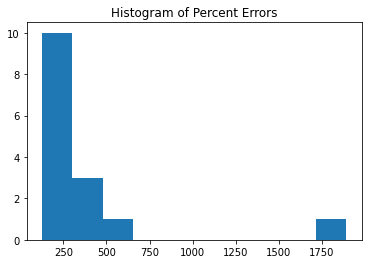

In [167]:
uts.evaluate(y_yhat)

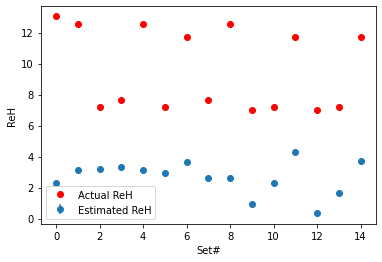

In [168]:
uts.plotError(y_yhat, err, "ReH")

# ReE

Mean percent error:  8754.758580753112
RMSE:  48.900874436063376
RMSE w yhat=mean:  2.525480507907797
R-squared:  -373.9256978718787


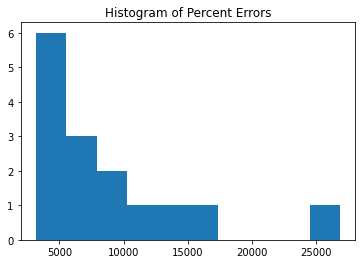

In [169]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)
uts.evaluate(y_yhat)

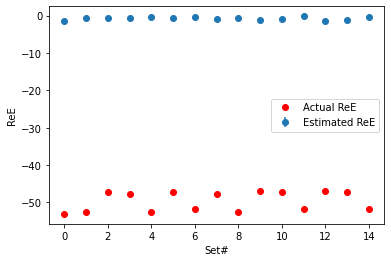

In [170]:
uts.plotError(y_yhat, err, "ReE")

# ReHtilde

Mean percent error:  197.65520384296627
RMSE:  11.586557652253285
RMSE w yhat=mean:  1.4030345621243816
R-squared:  -67.1980747944861


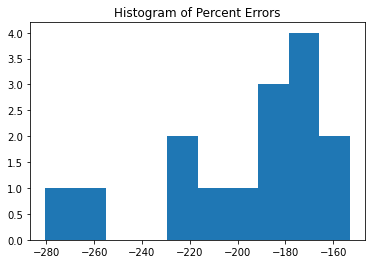

In [171]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
uts.evaluate(y_yhat)

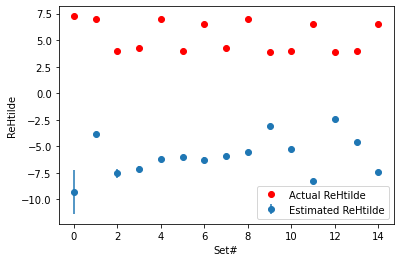

In [172]:
uts.plotError(y_yhat, err, "ReHtilde")

# Propagated Fs at 180

Use the compton form factors as inputs to TotalUUXS to estimate the distribution of F, then compare it with the baseline.

Mean percent error:  35.15507123731991
RMSE:  0.013388225895302672
RMSE w yhat=mean:  0.015855649879790133
R-squared:  0.28701898072047693


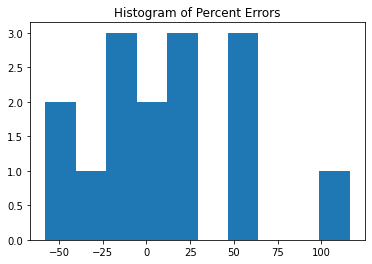

In [173]:
y_yhat, err = uts.y_yhat_errFs(results, data)
uts.evaluate(y_yhat)

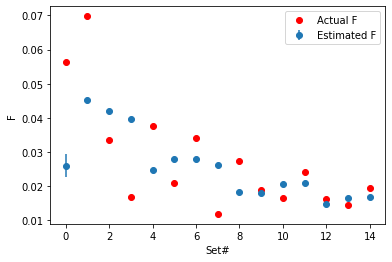

In [174]:
uts.plotError(y_yhat, err, "F")